# Pisarenko Estimator
Aimed and using the pisarenko.py file in this directory.

The following code runs a noiseless sinusoid through the estimator and plots it in a 3D graph widget.

In [29]:
import numpy as np
import scipy.signal as signal
# from pisarenko import pisarenko

Nruns = 100
results = np.zeros(shape=(Nruns*Nruns,3))
run_number = 0
for omega in np.linspace(np.pi/Nruns,np.pi,Nruns):
    for phi in np.linspace(np.pi/Nruns,np.pi,Nruns):
        results[run_number] =  [omega,phi,pisarenko(np.sin(omega*np.arange(0,1000)+phi))[0]]
        run_number = run_number + 1
        
all_true_frequencies = np.reshape(results[:,0],[Nruns,Nruns])
true_frequencies = all_true_frequencies[:,1]
true_phases = np.reshape(results[:,1],[Nruns,Nruns])[1,:]
frequency_estimates = np.reshape(results[:,2],[Nruns,Nruns])

In [49]:
%matplotlib widget

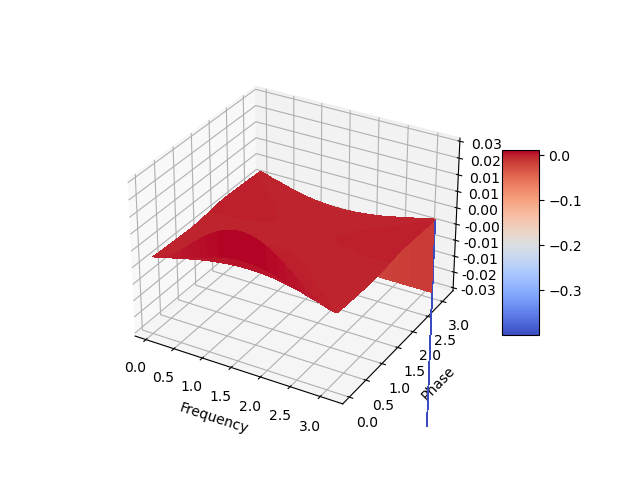

In [50]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
X, Y = np.meshgrid(true_frequencies, true_phases)
Z = np.subtract(frequency_estimates,all_true_frequencies)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-0.025, 0.025)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')
ax.set_xlabel('Frequency')
ax.set_ylabel('Phase')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [57]:
%matplotlib inline

In [98]:
from numpy.random import default_rng
rng = default_rng()

T = 1024
Nruns = 1000
Nsnrs = 100
omega_true = np.pi/np.sqrt(2)
phase_true = 2*np.pi/np.sqrt(2)

SNRs_in_dB = np.linspace(-30,30,Nsnrs)

x_noiseless = np.sin(omega_true*np.linspace(0,T,T) + phase_true)

results = np.zeros(shape=(len(SNRs_in_dB)*Nruns,2))
run_number = 0

for SNR in SNRs_in_dB:
    noise_gain = np.power(10,-SNR/20)
    for run in np.arange(Nruns):
        x = x_noiseless + rng.standard_normal(T)*noise_gain
        results[run_number] = [SNR,pisarenko(x)[0]- omega_true]
        run_number = run_number +1



Exception: Barf! -1.3512621593315939 -30509.05679390628 59872.415044730216 1024

In [75]:
frequency_estimate_errors = np.reshape(results[:,1],[len(SNRs_in_dB),Nruns])
snr_number = 0
error_power = np.zeros_like(SNRs_in_dB)
for SNR in SNRs_in_dB:
    error_power[snr_number] = np.mean(np.power(frequency_estimate_errors[snr_number,:],2))
    snr_number = snr_number + 1

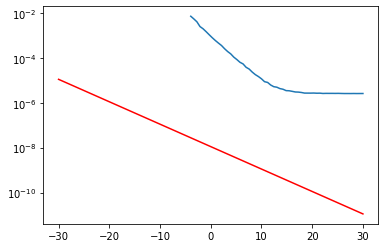

In [76]:
crlb = 12*np.power(10,-SNRs_in_dB/10)/(T*(T*T-1))

plt.semilogy(SNRs_in_dB, error_power)
plt.semilogy(SNRs_in_dB, crlb, 'r')


In [97]:
#
# PISARENKO Find the Pisarenko frequency estimates of the signals 
#          in each column of signal.
#
#          omegahat = pisarenko(signal)
#
# [1] V. F.  Pisarenko, "On the Estimation of Spectra by 
#     Means of Non-linear Functions of the Covariance Matrix,"
#     Geophys. J. Roy. astr. Soc., Vol. 28, pp. 511-531, 1972. 
#
# [2] V. F. Pisarenko, ``The Retrieval of Harmonics from a 
#     Covariance Function," Geophys. J. Roy. astr. Soc., 
#     Vol.   33, pp. 347-366, 1973. 
#
# $Id: pisarenko.m,v 1.2 1999/01/09 11:10:35 PeterK Exp PeterK $

# File: pisarenko.m
#
# Copyright (C) 1999 Peter J. Kootsookos
# 
# This software provided under the GNU General Public Licence, which
# is available from the website from which this file originated. For
# a copy, write to the Free Software Foundation, Inc., 675 Mass Ave, 
# Cambridge, MA 02139, USA.

import numpy as np
import scipy.signal as signal

def pisarenko(sig):

    if type(sig) is not np.ndarray:
        raise Exception("signal must be an np.ndarray")
        
    #
    # Initializations
    #
    eps = 1
    shape=sig.shape;
    t = shape[0]
    if t < 4:
        raise Exception("signal must be longer than 1 point")
        
    if (len(shape)==1):
        ns = 1
        sig = np.array([sig]).T
    else:
        ns = shape[1]
        
    xb = np.mean(sig, axis=0)
    
    if (len(xb.shape) == 1):
        xbm = np.multiply(np.ones([t,1]),xb)
    else:
        xbm = np.matmul(np.ones([t,1]),xb)

    sig=np.subtract(sig,xbm)        
      
    Rss1 = np.sum(sig[1:t-1,:]*sig[0:t-2,:], axis=0)
    Rss2 = np.sum(sig[2:t-1,:]*sig[0:t-3,:], axis=0)
    
    alpha = ( Rss2 + np.sqrt(np.power(Rss2,2) + 8*np.power(Rss1,2)) ) / ( 4*Rss1 + eps ) ;
    
    if np.any(np.abs(alpha) > 1):
        raise Exception("Barf! " + str(alpha[0]) + " " + str(Rss1[0]) + " " + str(Rss2[0]) + " " + str(t))

    return np.real(np.arccos(alpha))

# Author: Peter J. Kootsookos (p.kootsookos@ieee.org)
#
# Based on: P.J. Kootsookos, S.J. Searle and B.G. Quinn, 
# "Frequency Estimation Algorithms," CRC for Robust and 
# Adaptive Systems Internal Report, June 1993.
#